In [1]:
import matplotlib.pyplot as plt
import torch
import cv2
import yaml
from torchvision import transforms
import numpy as np

from utils.datasets import letterbox
from utils.general import non_max_suppression_mask_conf

from detectron2.modeling.poolers import ROIPooler
from detectron2.structures import Boxes
from detectron2.utils.memory import retry_if_cuda_oom
from detectron2.layers import paste_masks_in_image


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with open('data/hyp.scratch.mask.yaml') as f:
    hyp = yaml.load(f, Loader=yaml.FullLoader)
weigths = torch.load('yolov7-mask.pt')
model = weigths['model']
model = model.half().to(device)
#model = model.float().to(device)
_ = model.eval()

In [5]:
print(device)

cuda:0


In [4]:
image = cv2.imread('dataset/used_raw_images/00008.jpg')  # 504x378 image
#image
image = letterbox(image, 640, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))
image = image.to(device)
image = image.half()

output = model(image)

/home/gaps-sccg/anaconda3/envs/yolov7mask/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [9]:
inf_out, train_out, attn, mask_iou, bases, sem_output = output['test'], output['bbox_and_cls'], output['attn'], output['mask_iou'], output['bases'], output['sem']

In [10]:
bases = torch.cat([bases, sem_output], dim=1)
nb, _, height, width = image.shape
names = model.names
pooler_scale = model.pooler_scale
pooler = ROIPooler(output_size=hyp['mask_resolution'], scales=(pooler_scale,), sampling_ratio=1, pooler_type='ROIAlignV2', canonical_level=2)

In [11]:
output, output_mask, output_mask_score, output_ac, output_ab = non_max_suppression_mask_conf(inf_out, attn, bases, pooler, hyp, conf_thres=0.25, iou_thres=0.65, merge=False, mask_iou=None)

In [12]:
pred, pred_masks = output[0], output_mask[0]
base = bases[0]
bboxes = Boxes(pred[:, :4])
original_pred_masks = pred_masks.view(-1, hyp['mask_resolution'], hyp['mask_resolution'])
pred_masks = retry_if_cuda_oom(paste_masks_in_image)( original_pred_masks, bboxes, (height, width), threshold=0.5)
pred_masks_np = pred_masks.detach().cpu().numpy()
pred_cls = pred[:, 5].detach().cpu().numpy()
pred_conf = pred[:, 4].detach().cpu().numpy()
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
nbboxes = bboxes.tensor.detach().cpu().numpy().astype(int)
pnimg = nimg.copy()

In [13]:
for one_mask, bbox, cls, conf in zip(pred_masks_np, nbboxes, pred_cls, pred_conf):
    if conf < 0.25:
        continue
    #print(1 - one_mask[400])
    #color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]
    pnimg[one_mask == False] = np.array([0, 0, 0])      
    break         
                        
    #pnimg[one_mask] = pnimg[one_mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5
    #pnimg = cv2.rectangle(pnimg, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)
                     

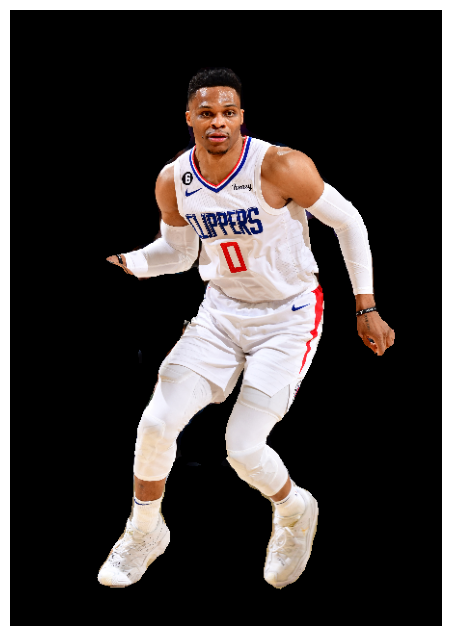

In [14]:
# coco example
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(pnimg)
plt.show()

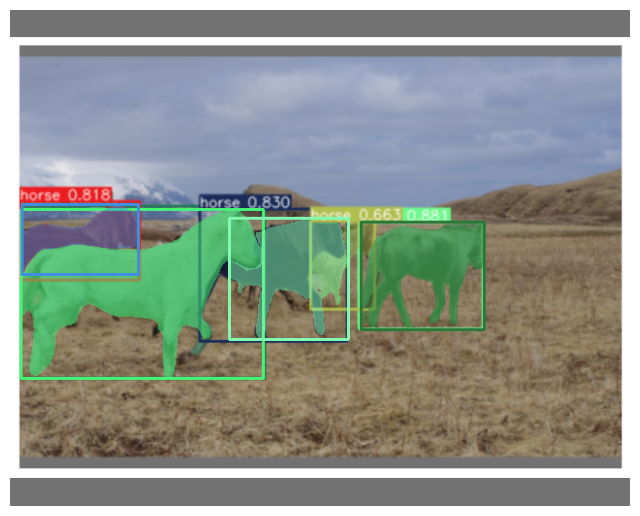

In [14]:
# cityscapes example
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(pnimg)
plt.show()